<a href="https://colab.research.google.com/github/PieroPastor/linnear-regression-optimization/blob/main/regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! sudo apt install nasm

# REGRESIÓN LINEAL

Ecuaciones matemáticas para la regresión lineal; donde $x$ es el arreglo con los inputs, $y$ los outputs, y $n$ el tamaño de datos.

$y = B_0  + B_1x$

$B_0 = \tfrac{∑y - B_1∑x}{n}$

$B_1 = \tfrac{n∑xy - ∑x∑y}{n∑x^2-(∑x)^2}$

Se experimentará con la función en la librería de scikit-learn, utilizaremos multiprocessing, una función secuencial en python, multihilo en C, y las instrucciones SIMD de assembly; para las que se utilizará el ensamblador $nasm$. Se realizarán las experimentaciones para datos float y double, ya que, al tener una relación de $\tfrac{1}{2}$, esto puede hacer que los tiempos de ejecución varíen, por las transacciones entre caché y ram.

## FLOATS

### CÓDIGO EXTERNO

Primero se elaborará el algoritmo en lenguaje ensamblador utilizando las instrucciones SIMD.

In [ ]:
%%file regresion_lineal_floats_simd.asm
section .text
    global regresion_lineal_floats_simd

;rdi <- pointer to x
;rsi <- pointer to y
;rdx <- number of data "n"
;rcx <- pointer to b

regresion_lineal_floats_simd:
    xorps xmm0, xmm0 ;Sumará los x*y
    xorps xmm1, xmm1 ;Sumará los x
    xorps xmm2, xmm2 ;Sumará los y
    xorps xmm3, xmm3 ;Sumará los x^2
    xorps xmm4, xmm4 ;Servirá de auxiliar 1
    xorps xmm5, xmm5 ;Servirá de auxiliar 2
    cvtsi2ss xmm6, rdx ;Guardará n para operar
    mov r9, 0
    cmp r9, rdx
    jl sumadores_x_y
ret

sumadores_x_y:
    mov r10, rdx
    sub r10, r9
    cmp r10, 3
    jle bucle_sobrantes ;Como para que el SIMD funcione se necesita en caso de floats un n que sea múltiplo de 4, se tomará el caso para los que puedan sobrar
    movaps xmm4, [rdi + r9*4] ;Se multiplica por 4, ya que son floats de 4 bytes
    movaps xmm5, xmm4
    haddps xmm5, xmm5
    haddps xmm5, xmm5
    addss xmm1, xmm5 ;Se le suma al sumador de x, 4 valores de x

    movaps xmm5, xmm4
    mulps xmm5, xmm5
    haddps xmm5, xmm5
    haddps xmm5, xmm5
    addss xmm3, xmm5 ;Se le suma al sumador de x^2, 4 valores de x^2

    movaps xmm5, [rsi + r9*4]
    mulps xmm4, xmm5
    haddps xmm4, xmm4
    haddps xmm4, xmm4
    addss xmm0, xmm4 ;Se le suma al sumador de x*y, 4 valores de x*y

    haddps xmm5, xmm5
    haddps xmm5, xmm5
    addss xmm2, xmm5 ;Se le suma al sumador de y, 4 valores de y

    add r9, 4 ;Se le suma 4 porque en cada xmmx entran 4 floats y debe saltarse los siguientes 4
    cmp r9, rdx
    jl sumadores_x_y
    jmp fin_algoritmo

bucle_sobrantes:
    movss xmm4, [rdi + r9*4] ;x
    movss xmm5, [rsi + r9*4] ;y
    addss xmm1, xmm4
    addss xmm2, xmm5
    mulss xmm5, xmm4
    addss xmm0, xmm5
    mulss xmm4, xmm4
    addss xmm3, xmm4
    inc r9
    cmp r9, rdx
    jl bucle_sobrantes
    jmp fin_algoritmo

fin_algoritmo:
    ;B1
    xorps xmm5, xmm5
    mulss xmm0, xmm6
    mulss xmm3, xmm6
    addss xmm5, xmm0
    movss xmm4, xmm1
    mulss xmm4, xmm2
    subss xmm5, xmm4
    movss xmm4, xmm1
    mulss xmm4, xmm4
    subss xmm3, xmm4
    divss xmm5, xmm3
    ;B0
    mulss xmm1, xmm5
    subss xmm2, xmm1
    divss xmm2, xmm6
    ;Guardar en memoria
    movss [rcx], xmm2
    movss [rcx+4], xmm5
ret

Overwriting regresion_lineal_floats_simd.asm


In [ ]:
! nasm -f elf64 regresion_lineal_floats_simd.asm -o regresion_lineal_floats_simd.o

In [ ]:
%%file regresion_lineal_floats_simd.c
extern void regresion_lineal_floats_simd(float *x, float *y, int n, float *b);

Overwriting regresion_lineal_floats_simd.c


In [ ]:
! gcc -shared -fPIC regresion_lineal_floats_simd.o regresion_lineal_floats_simd.c -o regresion_lineal_floats_simd.so

Ahora se elaborará el algoritmo en lenguaje C utilizando multithreading.

In [ ]:
%%file regresion_lineal_floats_multithreading.c
#include <stdio.h>
#include <stdlib.h>
#include <pthread.h>

typedef struct thread{
    pthread_t thr;
    int size;
    int id;
    float *x;
    float *y;
    float sum_x;
    float sum_y;
    float sum_xy;
    float sum_xx;
} thread;

void *multithread_function(void *threads){
    thread *aux_thread = (thread*) threads;
    aux_thread->sum_x = aux_thread->sum_y = aux_thread->sum_xy = aux_thread->sum_xx = 0;
    for(int i=0; i < aux_thread->size; i++){
        aux_thread->sum_x += aux_thread->x[i];
        aux_thread->sum_y += aux_thread->y[i];
        aux_thread->sum_xy += aux_thread->x[i] * aux_thread->y[i];
        aux_thread->sum_xx += aux_thread->x[i] * aux_thread->x[i];
    }
}

void reregresion_lineal_floats_multithreading(float *x, float *y, int n, float *b, int ths){
    float sum_x=0, sum_y=0, sum_xy=0, sum_xx=0;
    int size_thread=(n/ths);
    thread threads[ths];
    for(int i=0; i < ths; i++){
        threads[i].size = size_thread; //Tamaño de los hilos
        threads[i].id = i; //Id del hilo
        threads[i].x = x + i * size_thread; //Esta operación es para que apunte a un índice del arreglo y lo tome como inicio, por eso es comienzo + i * tamaño que debe saltarse porque otro hilo ya lo está haciendo
        threads[i].y = y + i * size_thread;
    }

    multithread_function((void *)&threads[0]);

    if(ths > 1){
        for (int i = 1; i < ths; ++i) pthread_create(&threads[i].thr, NULL, multithread_function, (void *)&threads[i]);
        for (int i = 1; i < ths; ++i) pthread_join(threads[i].thr, NULL);
    }

    for(int i=0; i < ths; i++){
        sum_x += threads[i].sum_x;
        sum_y += threads[i].sum_y;
        sum_xy += threads[i].sum_xy;
        sum_xx += threads[i].sum_xx;
    }
    if(ths > 1){
        b[1] = (n * sum_xy - sum_x * sum_y)/(n * sum_xx - sum_x * sum_x);
        b[0] = (sum_y - (b[1])*sum_x) / n;
    }
}

Overwriting regresion_lineal_floats_multithreading.c


In [ ]:
! gcc -shared -fPIC regresion_lineal_floats_multithreading.c -o regresion_lineal_floats_multithreading.so

### PYTHON

Se importarán las librerías necesarias para calcular tiempos y trabajar con multiprocessing en python.

In [ ]:
import os
import time
import ctypes
import numpy as np
from itertools import repeat
import multiprocessing
#import tensorflow as tf
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn import linear_model as lm

In [ ]:
N = 1000003 #Es el tamaño para la data

Con estas dos primeras funciones se operará con los arreglos, estas si bien iteran, sus tamaños son menores y se encuentran repartidos entre el número de procesos que idealmente es el número de núcleos del computador. La tercera función es la que se encarga de crear los procesos extras para ejecutarlos en paralelo y así resolver el problema utilizando multiprocessing.

In [ ]:
def sumador_x_y_floats_multiprocessing(x, y):
    sum_x = sum_y = sum_xy = sum_xx = 0
    for i in range(len(x)):
        sum_x += x[i]
        sum_y += y[i]
        sum_xy += x[i] * y[i]
        sum_xx += x[i] * x[i]
    return sum_x, sum_y, sum_xy, sum_xx

def sumador_columnas_floats_multiprocessing(col):
    return sum(col)

def regresion_lineal_floats_multiprocessing(x, y):
    cpus = os.cpu_count()
    chunk_size = len(x) // cpus
    p = Pool(processes=cpus)
    args = zip((x[i*chunk_size:(i+1)*chunk_size] for i in range(cpus)), (y[i*chunk_size:(i+1)*chunk_size] for i in range(cpus))) #Se manda en multiproceso a conseguir todas las operaciones entre x e y en una matriz
    sumadores_prev = p.starmap(sumador_x_y_floats_multiprocessing, args)

    sumadores_prev = np.array(sumadores_prev)
    args = zip(sumadores_prev[:, i] for i in range (4)) #Se manda en multiproceso cada columna de la matriz para poder sumarlas simultaneamente
    sumadores = p.starmap(sumador_columnas_floats_multiprocessing, args)

    b1 = (len(y)*sumadores[2] - sumadores[0]*sumadores[1])/(len(y)*sumadores[3] - sumadores[0]*sumadores[0])
    b0 = (sumadores[1] - b1*sumadores[0])/len(y)
    return b0, b1

Se tiene la operación de los arreglos de manera secuencial con un simple for que itere todos los arreglos.

In [ ]:
def regresion_lineal_floats_secuencial(x, y):
    sum_x = sum_y = sum_xy = sum_xx = 0
    for i in range(len(y)):
        sum_x += x[i]
        sum_y += y[i]
        sum_xy += x[i] * y[i]
        sum_xx += x[i] * x[i]

    b1 = (len(y)*sum_xy - sum_x*sum_y)/(len(y)*sum_xx - sum_x*sum_x)
    b0 = (sum_y - b1*sum_x)/len(y)
    return b0, b1

Con las siguientes dos funciones se incluirán los algoritmos realizados en C y Assembly respectivamente.

In [ ]:
def regresion_lineal_floats_multithreading(x, y):
    tam = [0, 0]
    b = np.zeros_like(tam).astype(np.float32)
    lib = ctypes.CDLL('./regresion_lineal_floats_multithreading.so') #Si se opera en windows es .dll
    lib.reregresion_lineal_floats_multithreading.argtypes = [np.ctypeslib.ndpointer(dtype = np.float32),
                                                             np.ctypeslib.ndpointer(dtype = np.float32),
                                                             ctypes.c_int,
                                                             np.ctypeslib.ndpointer(dtype = np.float32),
                                                             ctypes.c_int]
    lib.reregresion_lineal_floats_multithreading(x, y, len(x), b, os.cpu_count())
    return b[0], b[1]

In [ ]:
def regresion_lineal_floats_simd(x, y):
    tam = [0, 0]
    b = np.zeros_like(tam).astype(np.float32)
    lib = ctypes.CDLL('./regresion_lineal_floats_simd.so') #Si se opera en windows es .dll
    lib.regresion_lineal_floats_simd.argtypes = [np.ctypeslib.ndpointer(dtype = np.float32),
                                                 np.ctypeslib.ndpointer(dtype = np.float32),
                                                 ctypes.c_int,
                                                 np.ctypeslib.ndpointer(dtype = np.float32)]
    lib.regresion_lineal_floats_simd(x, y, len(x), b)
    return b[0], b[1]

La siguiente función contendrá todo lo que se necesita para realizar una regresion lineal desde scikit-learn.

In [ ]:
def regresion_lineal_floats_sklearn(x, y):
    X = x.reshape(-1, 1)
    modelo = lm.LinearRegression()
    modelo.fit(X, y)
    return modelo.intercept_, modelo.coef_[0]

También se probará con una función secuencial pero que utilice directamente la gpu gracias a la librería tensorflow.

In [ ]:
def regresion_lineal_floats_gpu(x, y):
    sum_x = sum_y = sum_xy = sum_xx = 0
    with tf.device('/GPU:0'):
        for i in range(len(y)):
            sum_x += x[i]
            sum_y += y[i]
            sum_xy += x[i] * y[i]
            sum_xx += x[i] * x[i]

    b1 = (len(y)*sum_xy - sum_x*sum_y)/(len(y)*sum_xx - sum_x*sum_x)
    b0 = (sum_y - b1*sum_x)/len(y)
    return b0, b1

Finalmente se utilizará una séptima función que utilizará las operaciones entre matrices y arreglos de la propia librería de numpy. Estas operaciones nacen de la definición de regresión lineal.

In [ ]:
def regresion_lineal_floats_numpy(x, y):
    X = x.reshape(-1, 1)
    X_b = np.c_[np.ones((len(x), 1)), X] #Se necesita la columa de unos para el B0
    b = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return b[0], b[1]

Se necesita de una función para calcular el error en los coeficientes conseguidos.

In [ ]:
def ecuacion_recta(x, b0, b1):
    return b0 + b1*x

In [ ]:
def error_absoluto_medio(x, y, b0, b1):
    sum = 0.0
    for i in range (len(x)):
        sum += np.abs(y[i] - ecuacion_recta(x[i], b0, b1))
    return sum/len(x)

In [ ]:
x = np.random.exponential(scale=10, size=N).astype(np.float32) #Números aleatorios mayores a 0 float32
y = np.random.exponential(scale=10, size=N).astype(np.float32) #Números aleatorios mayores a 0 float32
#x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).astype(np.float32)
#y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).astype(np.float32)

#print("ARREGLO X: ", x)
#print("ARREGLO Y: ", y)

tic1 = time.perf_counter()
b0_sec, b1_sec = regresion_lineal_floats_secuencial(x, y)
toc1 = time.perf_counter()
print("\nCOEFICIENTES SECUENCIAL     : ", b0_sec, b1_sec)
print("ERROR SECUENCIAL            : ", error_absoluto_medio(x, y, b0_sec, b1_sec))

tic2 = time.perf_counter()
b0_mp, b1_mp = regresion_lineal_floats_multiprocessing(x, y)
toc2 = time.perf_counter()
print("COEFICIENTES MULTIPROCESSING: ", b0_mp, b1_mp)
print("ERROR MULTIPROCESSING       : ", error_absoluto_medio(x, y, b0_mp, b1_mp))

tic3 = time.perf_counter()
b0_mt, b1_mt = regresion_lineal_floats_multithreading(x, y)
toc3 = time.perf_counter()
print("COEFICIENTES MULTITHREADING : ", b0_mt, b1_mt)
print("ERROR MULTITHREADING        : ", error_absoluto_medio(x, y, b0_mt, b1_mt))

tic4 = time.perf_counter()
b0_simd, b1_simd = regresion_lineal_floats_simd(x, y)
toc4 = time.perf_counter()
print("COEFICIENTES ASSEMBLY SIMD  : ", b0_simd, b1_simd)
print("ERROR ASSEMBLY SIMD         : ", error_absoluto_medio(x, y, b0_simd, b1_simd))

tic5 = time.perf_counter()
b0_sk, b1_sk = regresion_lineal_floats_sklearn(x, y)
toc5 = time.perf_counter()
print("COEFICIENTES SCIKIT-LEARN   : ", b0_sk, b1_sk)
print("ERROR SCIKIT-LEARN          : ", error_absoluto_medio(x, y, b0_sk, b1_sk))
'''
tic6 = time.perf_counter()
b0_gpu, b1_gpu = regresion_lineal_floats_gpu(x, y)
toc6 = time.perf_counter()
print("COEFICIENTES GPU            : ", b0_gpu, b1_gpu)
print("ERROR GPU                   : ", error_absoluto_medio(x, y, b0_gpu, b1_gpu))
'''
tic7 = time.perf_counter()
b0_np, b1_np = regresion_lineal_floats_numpy(x, y)
toc7 = time.perf_counter()
print("COEFICIENTES NUMPY          : ", b0_np, b1_np)
print("ERROR NUMPY                 : ", error_absoluto_medio(x, y, b0_np, b1_np))

print("\nTIEMPOS DE EJECUCIÓN")
print("TIEMPO SECUENCIAL     : ", toc1-tic1)
print("TIEMPO MULTIPROCESSING: ", toc2-tic2)
print("TIEMPO MULTITHREADING : ", toc3-tic3)
print("TIEMPO ASSEMBLY SIMD  : ", toc4-tic4)
print("TIEMPO SCIKIT-LEARN   : ", toc5-tic5)
#print("TIEMPO GPU            : ", toc6-tic6)
print("TIEMPO NUMPY          : ", toc7-tic7)


COEFICIENTES SECUENCIAL     :  10.014751640416119 -0.000890914784436793
ERROR SECUENCIAL            :  7.368216814957836
COEFICIENTES MULTIPROCESSING:  10.014676766230512 -0.0008874118157229106
ERROR MULTIPROCESSING       :  7.368206242426471
COEFICIENTES MULTITHREADING :  10.014795 -0.00090937945
ERROR MULTITHREADING        :  7.368179412166323
COEFICIENTES ASSEMBLY SIMD  :  10.014784 -0.0008913828
ERROR ASSEMBLY SIMD         :  7.368224121809072
COEFICIENTES SCIKIT-LEARN   :  10.0147505 -0.0008909139
ERROR SCIKIT-LEARN          :  7.3682165098414565
COEFICIENTES NUMPY          :  10.01475164006023 -0.0008909147488219013
ERROR NUMPY                 :  7.368216814957876

TIEMPOS DE EJECUCIÓN
TIEMPO SECUENCIAL     :  1.5954812600000423
TIEMPO MULTIPROCESSING:  0.932463559000098
TIEMPO MULTITHREADING :  0.026385064999999486
TIEMPO ASSEMBLY SIMD  :  0.006653408000033778
TIEMPO SCIKIT-LEARN   :  0.07951943700004449
TIEMPO NUMPY          :  0.0979305780000459


### PRUEBA RESULTADOS

Se analizarán las predicciones conseguidas ploteando las ecuaciones de recta, además de los puntos en el dataset.

In [ ]:
def plot_prediction(x, y, b0, b1, name):
    x_values = np.linspace(0, max(x), int(max(x)))
    y_secuencial = ecuacion_recta(x_values, b0, b1)
    plt.scatter(x, y, c="purple", alpha=0.5)
    plt.plot(x_values, y_secuencial, c="lime")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(name)
    plt.show()

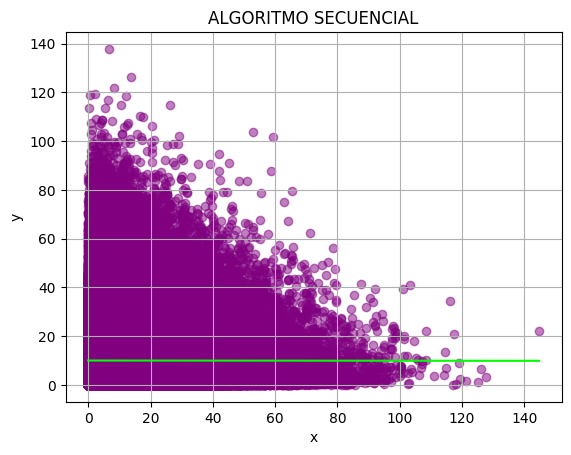

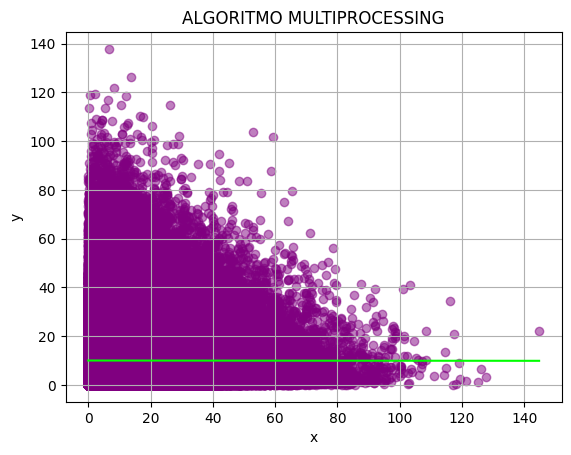

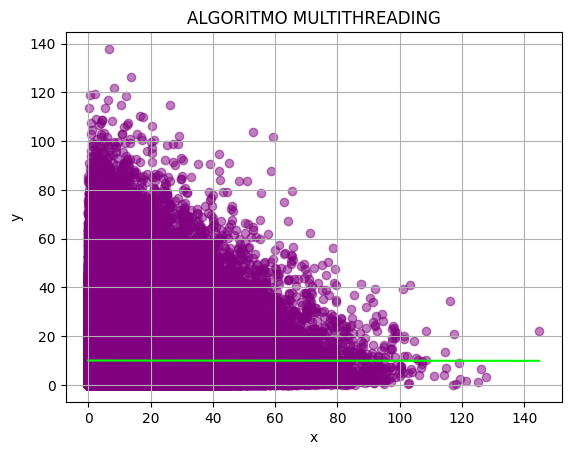

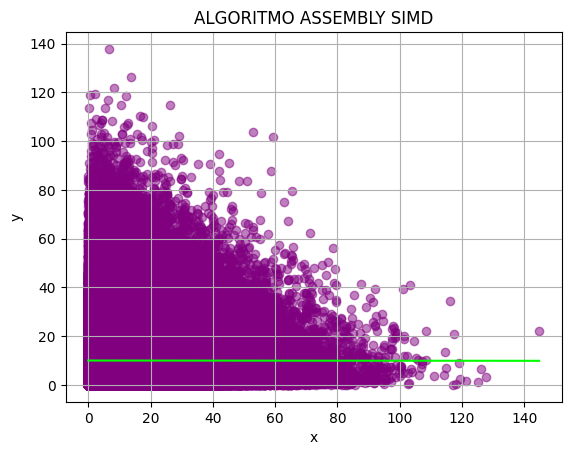

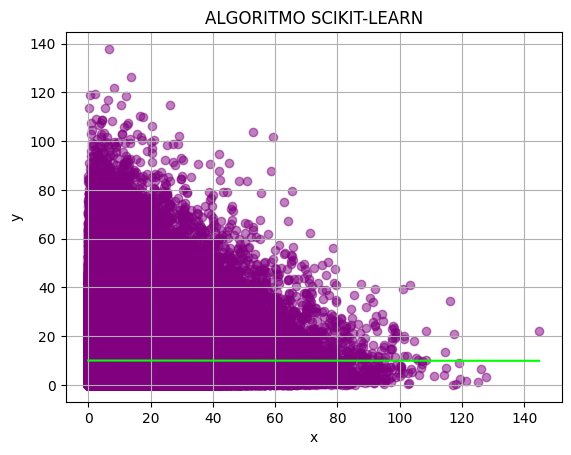

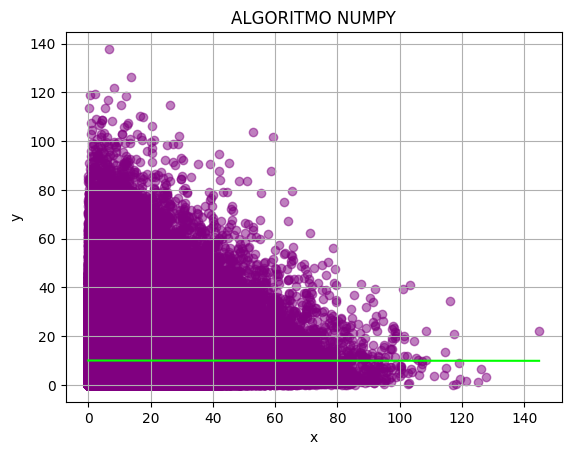

In [ ]:
plot_prediction(x, y, b0_sec, b1_sec, "ALGORITMO SECUENCIAL")
plot_prediction(x, y, b0_mp, b1_mp, "ALGORITMO MULTIPROCESSING")
plot_prediction(x, y, b0_mt, b1_mt, "ALGORITMO MULTITHREADING")
plot_prediction(x, y, b0_simd, b1_simd, "ALGORITMO ASSEMBLY SIMD")
plot_prediction(x, y, b0_sk, b1_sk, "ALGORITMO SCIKIT-LEARN")
#plot_prediction(x, y, b0_gpu, b1_gpu, "ALGORITMO GPU")
plot_prediction(x, y, b0_np, b1_np, "ALGORITMO NUMPY")

### ANÁLISIS DE TIEMPOS

Para un último análisis se utilizará una función en la cual tendremos un arreglo con N datos, que se guardarán los tiempos de ejecución por algoritmo.

In [ ]:
def save_exetime(x, y, n_exes, func):
    times = np.random.exponential(scale=0, size=n_exes).astype(np.float32)
    for i in range(n_exes):
        tic = time.perf_counter()
        b0, b1 = func(x, y)
        toc = time.perf_counter()
        times[i] = toc-tic
    media = np.mean(times)
    media_geometrica = np.prod(times) ** (1.0 / len(times))
    media_armonica = len(times) / np.sum(1.0 / np.array(times))
    mediana = np.median(times)
    return media, media_geometrica, media_armonica, mediana

Se consiguen los arreglos para cada algoritmo que consisten a el promedio de tiempo, media geométrica, media armónica y mediana de cada uno. Esto tras n iteraciones que se definen previo a la ejecución de la función.

(1.7264382, 1.718490157223519, 1.7111997864133568, 1.6462393)
(1.0302845, 1.0166547986536432, 1.0047925016705401, 0.94826496)
(0.022187222, 0.022177993966394267, 0.02216877077251076, 0.02211528)
(0.006237472, 0.0062271606596261755, 0.0062172598378473064, 0.006102137)
(0.045923892, 0.044840188503717036, 0.04389573975913427, 0.03996717)
(0.047048032, 0.04684668835411831, 0.046664847618651584, 0.044956565)


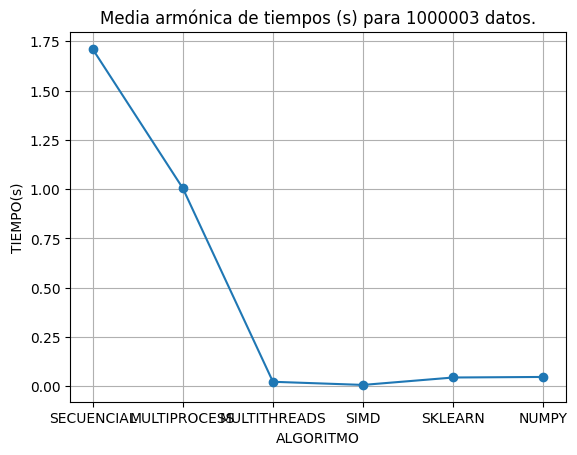

In [ ]:
f_sec = save_exetime(x, y, 15, regresion_lineal_floats_secuencial)
f_mpr = save_exetime(x, y, 15, regresion_lineal_floats_multiprocessing)
f_mth = save_exetime(x, y, 15, regresion_lineal_floats_multithreading)
f_smd = save_exetime(x, y, 15, regresion_lineal_floats_simd)
f_skl = save_exetime(x, y, 15, regresion_lineal_floats_sklearn)
#f_gpu = save_exetime(x, y, 20, regresion_lineal_floats_gpu)
f_npy = save_exetime(x, y, 15, regresion_lineal_floats_numpy)

print(f_sec)
print(f_mpr)
print(f_mth)
print(f_smd)
print(f_skl)
#print(f_gpu)
print(f_npy)

nombres = ["SECUENCIAL", "MULTIPROCESS", "MULTITHREADS", "SIMD", "SKLEARN", "NUMPY"]
medias_armonicas = [f_sec[2], f_mpr[2], f_mth[2], f_smd[2], f_skl[2], f_npy[2]]
plt.plot(nombres, medias_armonicas, 'o-')
plt.title(f"Media armónica de tiempos (s) para {len(x)} datos.")
plt.xlabel('ALGORITMO')
plt.ylabel('TIEMPO(s)')
plt.grid(True)
plt.show()


Tras todo este análisis se ve que al trabajar con floats, es mucho más eficiente utilizar las instrucciones SIMD, o como segunda opción el Multithreading; ya que, con respecto al tiempo de ejecución de un algoritmo 100% secuencial se tienen los siguientes speedups que se hallarán utilizando las medias armónicas previamente calculadas.

In [ ]:
print("SUP SECUENCIAL/MULTIPROCESSING: ", f_sec[2]/f_mpr[2])
print("SUP SECUENCIAL/MULTITHREADING : ", f_sec[2]/f_mth[2])
print("SUP SECUENCIAL/ASSEMBLY SIMD  : ", f_sec[2]/f_smd[2])
print("SUP SECUENCIAL/SCIKIT-LEARN   : ", f_sec[2]/f_skl[2])
#print("SUP SECUENCIAL/GPU            : ", f_sec[2]/f_gpu[2])
print("SUP SECUENCIAL/NUMPY          : ", f_sec[2]/f_npy[2])

SUP SECUENCIAL/MULTIPROCESSING:  1.7030379740775967
SUP SECUENCIAL/MULTITHREADING :  77.18965584394249
SUP SECUENCIAL/ASSEMBLY SIMD  :  275.23375748211464
SUP SECUENCIAL/SCIKIT-LEARN   :  38.98327709711904
SUP SECUENCIAL/NUMPY          :  36.669996233511824


## DOUBLES

### CÓDIGO EXTERNO

Primero se elaborará el algoritmo en lenguaje ensamblador utilizando las instrucciones SIMD.

In [ ]:
%%file regresion_lineal_doubles_simd.asm
section .text
    global regresion_lineal_doubles_simd

;rdi <- pointer to x
;rsi <- pointer to y
;rdx <- number of data "n"
;rcx <- pointer to b

regresion_lineal_doubles_simd:
    xorpd xmm0, xmm0 ;Sumará los x*y
    xorpd xmm1, xmm1 ;Sumará los x
    xorpd xmm2, xmm2 ;Sumará los y
    xorpd xmm3, xmm3 ;Sumará los x^2
    xorpd xmm4, xmm4 ;Servirá de auxiliar 1
    xorpd xmm5, xmm5 ;Servirá de auxiliar 2
    cvtsi2sd xmm6, rdx ;Guardará n para operar
    mov r9, 0
    cmp r9, rdx
    jl sumadores_x_y
ret

sumadores_x_y:
    mov r10, rdx
    sub r10, r9
    cmp r10, 1
    jle bucle_sobrantes ;Como para que el SIMD funcione se necesita en caso de floats un n que sea múltiplo de 4, se tomará el caso para los que puedan sobrar
    movapd xmm4, [rdi + r9*8] ;Se multiplica por 8, ya que son doubles de 8 bytes
    movapd xmm5, xmm4
    haddpd xmm5, xmm5
    addsd xmm1, xmm5 ;Se le suma al sumador de x, 2 valores de x

    movapd xmm5, xmm4
    mulpd xmm5, xmm5
    haddpd xmm5, xmm5
    addsd xmm3, xmm5 ;Se le suma al sumador de x^2, 2 valores de x^2

    movapd xmm5, [rsi + r9*8]
    mulpd xmm4, xmm5
    haddpd xmm4, xmm4
    addsd xmm0, xmm4 ;Se le suma al sumador de x*y, 2 valores de x*y

    haddpd xmm5, xmm5
    addsd xmm2, xmm5 ;Se le suma al sumador de y, 2 valores de y

    add r9, 2 ;Avanza de 2 en 2 porque en cada xmmx entran 2 doubles y debe saltarse los siguientes 2
    cmp r9, rdx
    jl sumadores_x_y
    jmp fin_algoritmo

bucle_sobrantes:
    movsd xmm4, [rdi + r9*8] ;x
    movsd xmm5, [rsi + r9*8] ;y
    addsd xmm1, xmm4
    addsd xmm2, xmm5
    mulsd xmm5, xmm4
    addsd xmm0, xmm5
    mulsd xmm4, xmm4
    addsd xmm3, xmm4
    inc r9
    cmp r9, rdx
    jl bucle_sobrantes
    jmp fin_algoritmo

fin_algoritmo:
    ;B1
    xorpd xmm5, xmm5
    mulsd xmm0, xmm6
    mulsd xmm3, xmm6
    addsd xmm5, xmm0
    movsd xmm4, xmm1
    mulsd xmm4, xmm2
    subsd xmm5, xmm4
    movsd xmm4, xmm1
    mulsd xmm4, xmm4
    subsd xmm3, xmm4
    divsd xmm5, xmm3
    ;B0
    mulsd xmm1, xmm5
    subsd xmm2, xmm1
    divsd xmm2, xmm6
    ;Guardar en memoria
    movsd [rcx], xmm2
    movsd [rcx+8], xmm5
ret

Writing regresion_lineal_doubles_simd.asm


In [ ]:
! nasm -f elf64 regresion_lineal_doubles_simd.asm -o regresion_lineal_doubles_simd.o

In [ ]:
%%file regresion_lineal_doubles_simd.c
extern void regresion_lineal_doubles_simd(double *x, double *y, int n, double *b);

Writing regresion_lineal_doubles_simd.c


In [ ]:
! gcc -shared -fPIC regresion_lineal_doubles_simd.o regresion_lineal_doubles_simd.c -o regresion_lineal_doubles_simd.so

Ahora se elaborará el algoritmo en lenguaje C utilizando multithreading.

In [ ]:
%%file regresion_lineal_doubles_multithreading.c
#include <stdio.h>
#include <stdlib.h>
#include <pthread.h>

typedef struct thread{
    pthread_t thr;
    int size;
    int id;
    double *x;
    double *y;
    double sum_x;
    double sum_y;
    double sum_xy;
    double sum_xx;
} thread;

void *multithread_function(void *threads){
    thread *aux_thread = (thread*) threads;
    aux_thread->sum_x = aux_thread->sum_y = aux_thread->sum_xy = aux_thread->sum_xx = 0;
    for(int i=0; i < aux_thread->size; i++){
        aux_thread->sum_x += aux_thread->x[i];
        aux_thread->sum_y += aux_thread->y[i];
        aux_thread->sum_xy += aux_thread->x[i] * aux_thread->y[i];
        aux_thread->sum_xx += aux_thread->x[i] * aux_thread->x[i];
    }
}

void regresion_lineal_doubles_multithreading(double *x, double *y, int n, double *b, int ths){
    float sum_x=0, sum_y=0, sum_xy=0, sum_xx=0;
    int size_thread=(n/ths);
    thread threads[ths];
    for(int i=0; i < ths; i++){
        threads[i].size = size_thread; //Tamaño de los hilos
        threads[i].id = i; //Id del hilo
        threads[i].x = x + i * size_thread; //Esta operación es para que apunte a un índice del arreglo y lo tome como inicio, por eso es comienzo + i * tamaño que debe saltarse porque otro hilo ya lo está haciendo
        threads[i].y = y + i * size_thread;
    }

    multithread_function((void *)&threads[0]);

    if(ths > 1){
        for (int i = 1; i < ths; ++i) pthread_create(&threads[i].thr, NULL, multithread_function, (void *)&threads[i]);
        for (int i = 1; i < ths; ++i) pthread_join(threads[i].thr, NULL);
    }

    for(int i=0; i < ths; i++){
        sum_x += threads[i].sum_x;
        sum_y += threads[i].sum_y;
        sum_xy += threads[i].sum_xy;
        sum_xx += threads[i].sum_xx;
    }
    if(ths > 1){
        b[1] = (n * sum_xy - sum_x * sum_y)/(n * sum_xx - sum_x * sum_x);
        b[0] = (sum_y - (b[1])*sum_x) / n;
    }
}

Writing regresion_lineal_doubles_multithreading.c


In [ ]:
! gcc -shared -fPIC regresion_lineal_doubles_multithreading.c -o regresion_lineal_doubles_multithreading.so

### PYTHON

Se importarán las librerías necesarias para calcular tiempos y trabajar con multiprocessing en python.

In [ ]:
import os
import time
import ctypes
import numpy as np
from itertools import repeat
import multiprocessing
#import tensorflow as tf
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn import linear_model as lm

In [ ]:
N = 1000003 #Es el tamaño para la data

Con estas dos primeras funciones se operará con los arreglos, estas si bien iteran, sus tamaños son menores y se encuentran repartidos entre el número de procesos que idealmente es el número de núcleos del computador. La tercera función es la que se encarga de crear los procesos extras para ejecutarlos en paralelo y así resolver el problema utilizando multiprocessing.

In [ ]:
def sumador_x_y_double_multiprocessing(x, y):
    sum_x = sum_y = sum_xy = sum_xx = 0
    for i in range(len(x)):
        sum_x += x[i]
        sum_y += y[i]
        sum_xy += x[i] * y[i]
        sum_xx += x[i] * x[i]
    return sum_x, sum_y, sum_xy, sum_xx

def sumador_columnas_double_multiprocessing(col):
    return sum(col)

def regresion_lineal_double_multiprocessing(x, y):
    cpus = os.cpu_count()
    chunk_size = len(x) // cpus
    p = Pool(processes=cpus)
    args = zip((x[i*chunk_size:(i+1)*chunk_size] for i in range(cpus)), (y[i*chunk_size:(i+1)*chunk_size] for i in range(cpus))) #Se manda en multiproceso a conseguir todas las operaciones entre x e y en una matriz
    sumadores_prev = p.starmap(sumador_x_y_double_multiprocessing, args)

    sumadores_prev = np.array(sumadores_prev)
    args = zip(sumadores_prev[:, i] for i in range (4)) #Se manda en multiproceso cada columna de la matriz para poder sumarlas simultaneamente
    sumadores = p.starmap(sumador_columnas_double_multiprocessing, args)

    b1 = (len(y)*sumadores[2] - sumadores[0]*sumadores[1])/(len(y)*sumadores[3] - sumadores[0]*sumadores[0])
    b0 = (sumadores[1] - b1*sumadores[0])/len(y)
    return b0, b1

Se tiene la operación de los arreglos de manera secuencial con un simple for que itere todos los arreglos.

In [ ]:
def regresion_lineal_double_secuencial(x, y):
    sum_x = sum_y = sum_xy = sum_xx = 0
    for i in range(len(y)):
        sum_x += x[i]
        sum_y += y[i]
        sum_xy += x[i] * y[i]
        sum_xx += x[i] * x[i]

    b1 = (len(y)*sum_xy - sum_x*sum_y)/(len(y)*sum_xx - sum_x*sum_x)
    b0 = (sum_y - b1*sum_x)/len(y)
    return b0, b1

Con las siguientes dos funciones se incluirán los algoritmos realizados en C y Assembly respectivamente.

In [ ]:
def regresion_lineal_double_multithreading(x, y):
    tam = [0, 0]
    b = np.zeros_like(tam).astype(np.double)
    lib = ctypes.CDLL('./regresion_lineal_doubles_multithreading.so') #Si se opera en windows es .dll
    lib.regresion_lineal_doubles_multithreading.argtypes = [np.ctypeslib.ndpointer(dtype = np.double),
                                                             np.ctypeslib.ndpointer(dtype = np.double),
                                                             ctypes.c_int,
                                                             np.ctypeslib.ndpointer(dtype = np.double),
                                                             ctypes.c_int]
    lib.regresion_lineal_doubles_multithreading(x, y, len(x), b, os.cpu_count())
    return b[0], b[1]

In [ ]:
def regresion_lineal_double_simd(x, y):
    tam = [0, 0]
    b = np.zeros_like(tam).astype(np.double)
    lib = ctypes.CDLL('./regresion_lineal_doubles_simd.so') #Si se opera en windows es .dll
    lib.regresion_lineal_doubles_simd.argtypes = [np.ctypeslib.ndpointer(dtype = np.double),
                                                 np.ctypeslib.ndpointer(dtype = np.double),
                                                 ctypes.c_int,
                                                 np.ctypeslib.ndpointer(dtype = np.double)]
    lib.regresion_lineal_doubles_simd(x, y, len(x), b)
    return b[0], b[1]

La siguiente función contendrá todo lo que se necesita para realizar una regresion lineal desde scikit-learn.

In [ ]:
def regresion_lineal_double_sklearn(x, y):
    X = x.reshape(-1, 1)
    modelo = lm.LinearRegression()
    modelo.fit(X, y)
    return modelo.intercept_, modelo.coef_[0]

También se probará con una función secuencial pero que utilice directamente la gpu gracias a la librería tensorflow.

In [ ]:
def regresion_lineal_double_gpu(x, y):
    sum_x = sum_y = sum_xy = sum_xx = 0
    with tf.device('/GPU:0'):
        for i in range(len(y)):
            sum_x += x[i]
            sum_y += y[i]
            sum_xy += x[i] * y[i]
            sum_xx += x[i] * x[i]

    b1 = (len(y)*sum_xy - sum_x*sum_y)/(len(y)*sum_xx - sum_x*sum_x)
    b0 = (sum_y - b1*sum_x)/len(y)
    return b0, b1

Finalmente se utilizará una séptima función que utilizará las operaciones entre matrices y arreglos de la propia librería de numpy. Estas operaciones nacen de la definición de regresión lineal.

In [ ]:
def regresion_lineal_double_numpy(x, y):
    X = x.reshape(-1, 1)
    X_b = np.c_[np.ones((len(x), 1)), X] #Se necesita la columa de unos para el B0
    b = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return b[0], b[1]

Se necesita de una función para calcular el error en los coeficientes conseguidos.

In [ ]:
def ecuacion_recta(x, b0, b1):
    return b0 + b1*x

In [ ]:
def error_absoluto_medio(x, y, b0, b1):
    sum = 0.0
    for i in range (len(x)):
        sum += np.abs(y[i] - ecuacion_recta(x[i], b0, b1))
    return sum/len(x)

In [ ]:
x = np.random.exponential(scale=10, size=N).astype(np.double) #Números aleatorios mayores a 0 float32
y = np.random.exponential(scale=10, size=N).astype(np.double) #Números aleatorios mayores a 0 float32
#x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).astype(np.float32)
#y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).astype(np.float32)

#print("ARREGLO X: ", x)
#print("ARREGLO Y: ", y)

tic1 = time.perf_counter()
b0_sec, b1_sec = regresion_lineal_double_secuencial(x, y)
toc1 = time.perf_counter()
print("\nCOEFICIENTES SECUENCIAL     : ", b0_sec, b1_sec)
print("ERROR SECUENCIAL            : ", error_absoluto_medio(x, y, b0_sec, b1_sec))

tic2 = time.perf_counter()
b0_mp, b1_mp = regresion_lineal_double_multiprocessing(x, y)
toc2 = time.perf_counter()
print("COEFICIENTES MULTIPROCESSING: ", b0_mp, b1_mp)
print("ERROR MULTIPROCESSING       : ", error_absoluto_medio(x, y, b0_mp, b1_mp))

tic3 = time.perf_counter()
b0_mt, b1_mt = regresion_lineal_double_multithreading(x, y)
toc3 = time.perf_counter()
print("COEFICIENTES MULTITHREADING : ", b0_mt, b1_mt)
print("ERROR MULTITHREADING        : ", error_absoluto_medio(x, y, b0_mt, b1_mt))

tic4 = time.perf_counter()
b0_simd, b1_simd = regresion_lineal_double_simd(x, y)
toc4 = time.perf_counter()
print("COEFICIENTES ASSEMBLY SIMD  : ", b0_simd, b1_simd)
print("ERROR ASSEMBLY SIMD         : ", error_absoluto_medio(x, y, b0_simd, b1_simd))

tic5 = time.perf_counter()
b0_sk, b1_sk = regresion_lineal_double_sklearn(x, y)
toc5 = time.perf_counter()
print("COEFICIENTES SCIKIT-LEARN   : ", b0_sk, b1_sk)
print("ERROR SCIKIT-LEARN          : ", error_absoluto_medio(x, y, b0_sk, b1_sk))
'''
tic6 = time.perf_counter()
b0_gpu, b1_gpu = regresion_lineal_double_gpu(x, y)
toc6 = time.perf_counter()
print("COEFICIENTES GPU            : ", b0_gpu, b1_gpu)
print("ERROR GPU                   : ", error_absoluto_medio(x, y, b0_gpu, b1_gpu))
'''
tic7 = time.perf_counter()
b0_np, b1_np = regresion_lineal_double_numpy(x, y)
toc7 = time.perf_counter()
print("COEFICIENTES NUMPY          : ", b0_np, b1_np)
print("ERROR NUMPY                 : ", error_absoluto_medio(x, y, b0_np, b1_np))

print("\nTIEMPOS DE EJECUCIÓN")
print("TIEMPO SECUENCIAL     : ", toc1-tic1)
print("TIEMPO MULTIPROCESSING: ", toc2-tic2)
print("TIEMPO MULTITHREADING : ", toc3-tic3)
print("TIEMPO ASSEMBLY SIMD  : ", toc4-tic4)
print("TIEMPO SCIKIT-LEARN   : ", toc5-tic5)
#print("TIEMPO GPU            : ", toc6-tic6)
print("TIEMPO NUMPY          : ", toc7-tic7)


COEFICIENTES SECUENCIAL     :  9.99715038983673 0.0006941862000811405
ERROR SECUENCIAL            :  7.358156466438525
COEFICIENTES MULTIPROCESSING:  9.997089598326426 0.0006975348373115221
ERROR MULTIPROCESSING       :  7.358149294173428
COEFICIENTES MULTITHREADING :  9.997088030476613 0.0006975996075198054
ERROR MULTITHREADING        :  7.358149052066681
COEFICIENTES ASSEMBLY SIMD  :  9.997150389836367 0.0006941862001214869
ERROR ASSEMBLY SIMD         :  7.358156466438536
COEFICIENTES SCIKIT-LEARN   :  9.997150389836499 0.0006941862000970521
ERROR SCIKIT-LEARN          :  7.358156466438507
COEFICIENTES NUMPY          :  9.997150389836538 0.0006941862000976035
ERROR NUMPY                 :  7.358156466438513

TIEMPOS DE EJECUCIÓN
TIEMPO SECUENCIAL     :  1.2932248099999697
TIEMPO MULTIPROCESSING:  0.9906671940000251
TIEMPO MULTITHREADING :  0.02499687800002448
TIEMPO ASSEMBLY SIMD  :  0.006733583999903203
TIEMPO SCIKIT-LEARN   :  0.09866601999999602
TIEMPO NUMPY          :  0.0438682

### PRUEBA RESULTADOS

Se analizarán las predicciones conseguidas ploteando las ecuaciones de recta, además de los puntos en el dataset. Para esto se utilizará la funcion plot_prediction declarada al momento de trabajar con floats.

In [ ]:
def plot_prediction(x, y, b0, b1, name):
    x_values = np.linspace(0, max(x), int(max(x)))
    y_secuencial = ecuacion_recta(x_values, b0, b1)
    plt.scatter(x, y, c="purple", alpha=0.5)
    plt.plot(x_values, y_secuencial, c="lime")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(name)
    plt.show()

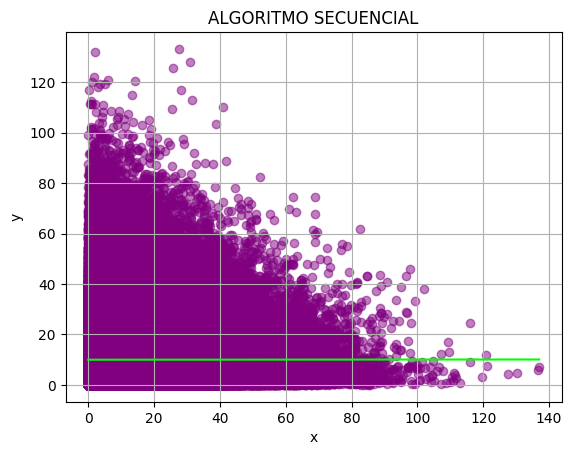

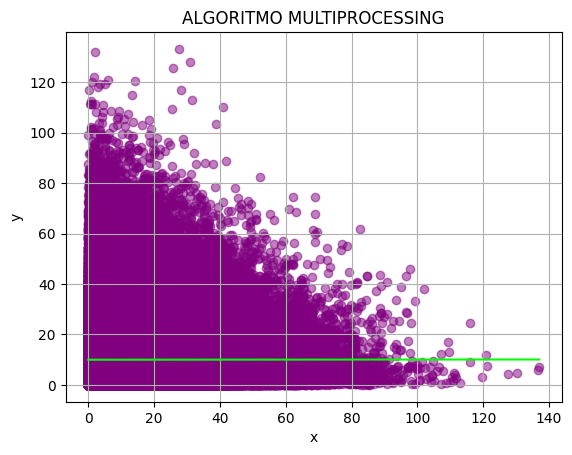

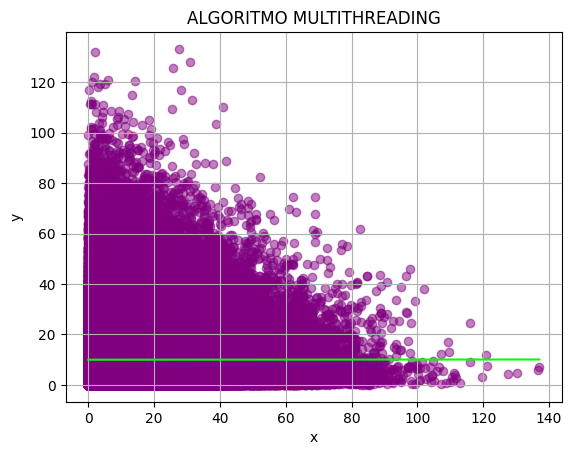

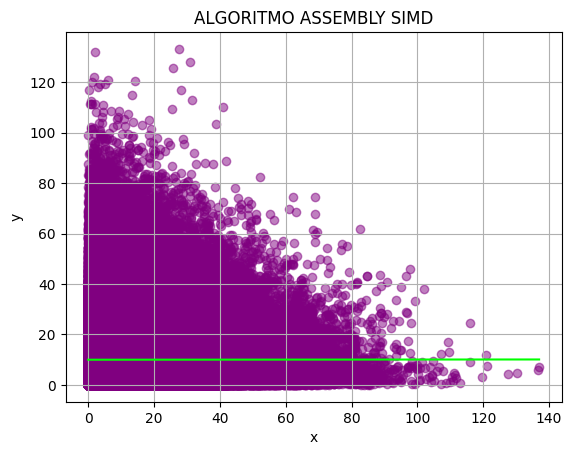

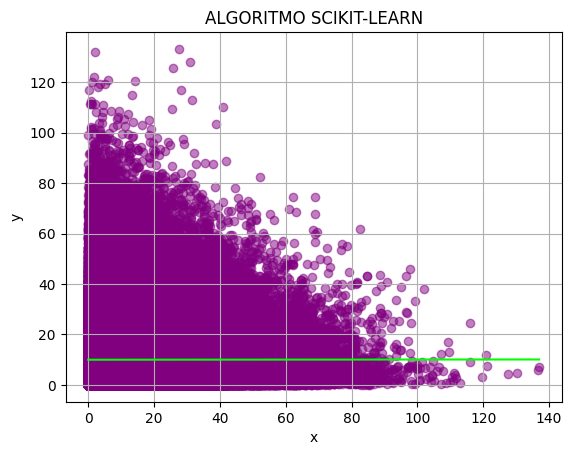

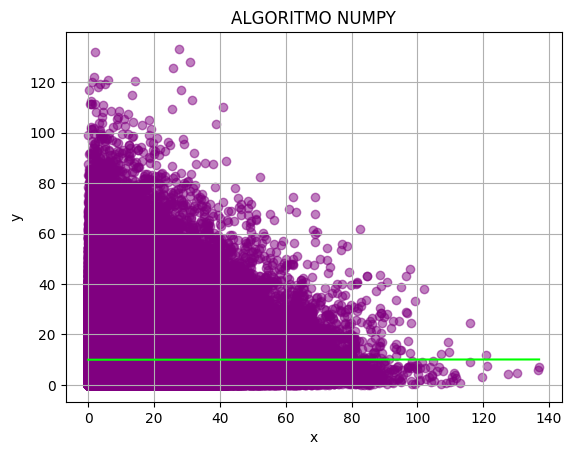

In [ ]:
plot_prediction(x, y, b0_sec, b1_sec, "ALGORITMO SECUENCIAL")
plot_prediction(x, y, b0_mp, b1_mp, "ALGORITMO MULTIPROCESSING")
plot_prediction(x, y, b0_mt, b1_mt, "ALGORITMO MULTITHREADING")
plot_prediction(x, y, b0_simd, b1_simd, "ALGORITMO ASSEMBLY SIMD")
plot_prediction(x, y, b0_sk, b1_sk, "ALGORITMO SCIKIT-LEARN")
#plot_prediction(x, y, b0_gpu, b1_gpu, "ALGORITMO GPU")
plot_prediction(x, y, b0_np, b1_np, "ALGORITMO NUMPY")

### ANÁLISIS TIEMPOS

Se consiguen los arreglos para cada algoritmo que consisten a el promedio de tiempo, media geométrica, media armónica y mediana de cada uno. Esto tras n iteraciones que se definen previo a la ejecución de la función. Para este proceso se utilizó la función save_exetime declarada al momento de trabajar con floats.

In [ ]:
def save_exetime(x, y, n_exes, func):
    times = np.random.exponential(scale=0, size=n_exes).astype(np.float32)
    for i in range(n_exes):
        tic = time.perf_counter()
        b0, b1 = func(x, y)
        toc = time.perf_counter()
        times[i] = toc-tic
    media = np.mean(times)
    media_geometrica = np.prod(times) ** (1.0 / len(times))
    media_armonica = len(times) / np.sum(1.0 / np.array(times))
    mediana = np.median(times)
    return media, media_geometrica, media_armonica, mediana

(2.1219316, 2.075806237486618, 2.0265395269289574, 2.1418128)
(1.3402678, 1.2967134098514752, 1.2613990855228747, 1.1543183)
(0.03873371, 0.038723717524463915, 0.03871364708043242, 0.038826786)
(0.008386774, 0.008363744506157414, 0.008341572174557173, 0.008126462)
(0.0928434, 0.08681057897670853, 0.08289375990542232, 0.07849674)
(0.085690565, 0.08352315876595308, 0.08154708517947426, 0.08643612)


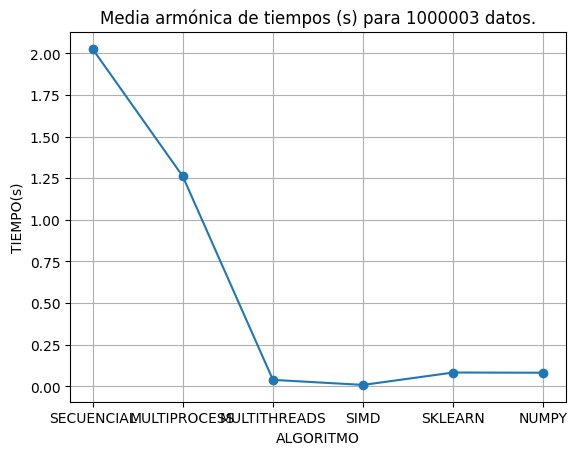

In [ ]:
d_sec = save_exetime(x, y, 15, regresion_lineal_double_secuencial)
d_mpr = save_exetime(x, y, 15, regresion_lineal_double_multiprocessing)
d_mth = save_exetime(x, y, 15, regresion_lineal_double_multithreading)
d_smd = save_exetime(x, y, 15, regresion_lineal_double_simd)
d_skl = save_exetime(x, y, 15, regresion_lineal_double_sklearn)
#d_gpu = save_exetime(x, y, 20, regresion_lineal_double_gpu)
d_npy = save_exetime(x, y, 15, regresion_lineal_double_numpy)

print(d_sec)
print(d_mpr)
print(d_mth)
print(d_smd)
print(d_skl)
#print(d_gpu)
print(d_npy)

nombres = ["SECUENCIAL", "MULTIPROCESS", "MULTITHREADS", "SIMD", "SKLEARN", "NUMPY"]
medias_armonicas = [d_sec[2], d_mpr[2], d_mth[2], d_smd[2], d_skl[2], d_npy[2]]
plt.plot(nombres, medias_armonicas, 'o-')
plt.title(f"Media armónica de tiempos (s) para {len(x)} datos.")
plt.xlabel('ALGORITMO')
plt.ylabel('TIEMPO(s)')
plt.grid(True)
plt.show()


Tras todo este análisis se ve que al trabajar con floats, es mucho más eficiente utilizar las instrucciones SIMD, o como segunda opción el Multithreading; ya que, con respecto al tiempo de ejecución de un algoritmo 100% secuencial se tienen los siguientes speedups que se hallarán utilizando las medias armónicas previamente calculadas.

In [ ]:
print("SUP SECUENCIAL/MULTIPROCESSING: ", d_sec[2]/d_mpr[2])
print("SUP SECUENCIAL/MULTITHREADING : ", d_sec[2]/d_mth[2])
print("SUP SECUENCIAL/ASSEMBLY SIMD  : ", d_sec[2]/d_smd[2])
print("SUP SECUENCIAL/SCIKIT-LEARN   : ", d_sec[2]/d_skl[2])
#print("SUP SECUENCIAL/GPU            : ", d_sec[2]/d_gpu[2])
print("SUP SECUENCIAL/NUMPY          : ", d_sec[2]/d_npy[2])

SUP SECUENCIAL/MULTIPROCESSING:  1.606580780173086
SUP SECUENCIAL/MULTITHREADING :  52.346902959531796
SUP SECUENCIAL/ASSEMBLY SIMD  :  242.944553439237
SUP SECUENCIAL/SCIKIT-LEARN   :  24.447431618992056
SUP SECUENCIAL/NUMPY          :  24.851158351875046


## COMPARACIÓN FLOATS Y DOUBLES

Para comparar los tiempos que le toma a cada algoritmo poder realizar una regresión lineal, se procederán a usar las medias armónicas halladas previamente para cada tipo de dato y así tener un gráfico donde se aprecie la variación de tiempo.

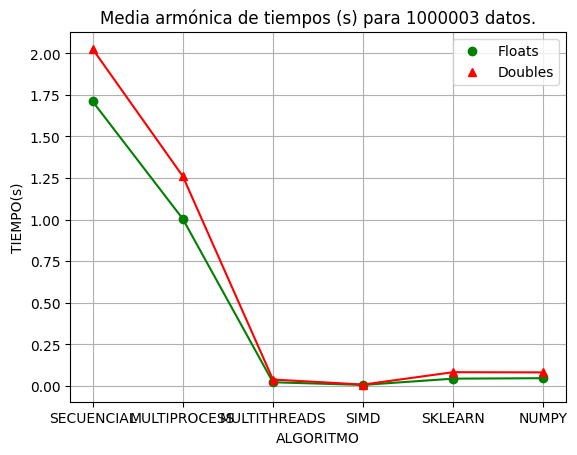

In [ ]:
nombres = ["SECUENCIAL", "MULTIPROCESS", "MULTITHREADS", "SIMD", "SKLEARN", "NUMPY"]
medias_armonicas_f = [f_sec[2], f_mpr[2], f_mth[2], f_smd[2], f_skl[2], f_npy[2]]
medias_armonicas_d = [d_sec[2], d_mpr[2], d_mth[2], d_smd[2], d_skl[2], d_npy[2]]
plt.plot(nombres, medias_armonicas_f, 'go', label="Floats")
plt.plot(nombres, medias_armonicas_f, 'g-')
plt.plot(nombres, medias_armonicas_d, 'r^', label="Doubles")
plt.plot(nombres, medias_armonicas_d, 'r-')
plt.title(f"Media armónica de tiempos (s) para {len(x)} datos.")
plt.xlabel('ALGORITMO')
plt.ylabel('TIEMPO(s)')
plt.legend()
plt.grid(True)
plt.show()

Para saber el speedup correspondiente a trabajar con doubles o con floats, se comparará el mejor tiempo de cada tipo de dato.

In [ ]:
print("SUP FLOAT/DOUBLE: ", min(medias_armonicas_f)/min(medias_armonicas_d))

SUP FLOAT/DOUBLE:  0.7453342976292548
